<center> <h1>Decision Tree - Alaa Bakhti </h1></center>

- Decision Trees are a __non-parametric supervised__ learning method that can be used for both classification and regression. They essentially __encode a set of if-then-else rules__ that can be used to predict target variable given data features. These if-then-else rules are formed using the training dataset with the aim to satisfy as many training data instances as possible (no attributes left to imporve classifier...).
- Decision trees __can model any type of function for classification or regression__. But they are highly prone to __overfitting and bias towards training data__. To tackle this problem, many pruning algorithms are used on the decision trees to improve their generalization.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tools.tools as tools
from tools2 import test_tree, benchmark_models, custom_plot
from decision_tree_classic import DecisionTreeClassic
from decision_tree_continuous import DecisionTreeContinuous
from split_metrics import entropy
from split_metrics import gini_impurity as gini

In [2]:
# All datasets should be in the dataset folder
dataset_dict = {
    'tennis': {'label': 'PlayTennis', 'filename': 'play_tennis.csv'},
    'mushrooms' : {'label': 'class', 'filename': 'mushrooms.csv'},
    'iris' : {'label': 'class', 'filename': 'iris.csv'},
    'spambase' : {'label': 'spam', 'filename': 'spambase.csv'},
    'magic_telescope' : {'label': 'class', 'filename': 'magic.csv'},
    'pima' : {'label': 'class', 'filename': 'pima.csv'}
}

data, label, attribute_list = tools.get_dataset("tennis", dataset_dict)
target_vector = data[label]; attribute_vector = data[attribute_list[0]]

# Split metrics
- Impurity: Chance of being incorrect if we randomly assign a label to an example in the same set.
- Measuring impurity.
- A dataset is pure (homogenous) if it contains a single class otherwise it is said to be impure.
- Several indices can be used to measeure the degree of impurety. Here we will only focus on:
    - __Entropy__
    - __Information gain__ 
    - __Gain ratio__
    - __Gini index__

## 1. Entropy:

### 1.1 Entropy for a vector:
- The bigger the entropy, the larger the disorder in the split branchs
- Measure of impurity in a bunch of examples
- A measure of disorder in a dataset
- __Minimal__ (0) : all samples at a node belong to the same class (homogeneous).
- __Maximal__ : uniform class distribution (all classes have the same number of occurences).

- A calculation on a vector of __categorical__ variable values.
- A summation across each of the possible values that that vector can take on.
$$Vector \ Entropy\ (\vec{attribute}_{j}) = \sum_{v\ in\ V_j} - p(v)\ \log_2(\ p(v))$$
where
    - __attribute__ : possible attributes in the dataset, each attribute is represented as a vector of values.
    - __$V_j$__ : possible values for the $attribute_j$.  Eg: ($V_j$ = (Red, Blue ..)) if $attribute_j$ = Color
    
    - $p (v)$ : the probability of the value v in the $attribute_j$
    
$$p (v) = \frac{\mathbf{card}(v)}{\mathbf{card}(attribute_j)}$$

In [3]:
entropy.get_vector_entropy(attribute_vector)

1.5774062828523454

### 1.2 Entropy for a partition:
- Partition the vector $\vec{A}$ according to some other vector $\vec{D}$
- For each of those partitions, we calculate the entropy and we take the weighed average of that entropy

$$Partition \ Entropy\ (\ \vec{label}\ ,\ \vec{attribute}_{j}\ ) = \sum_{v\ in\ V_j} p(v)\ E\ (\ \vec{label}_{v})$$
where $label_j$ is the label'vector with only the values corresponding to v.
* For exemple: if V = {Red, Blue} and label = {Yes, No} than
    - If we have:
    - v = Red -- label = {Yes : 2, No : 3}
    - v = Blue --  label =  {Yes : 4, No : 1}
    * Than $\ \vec{label}_{Red}\ $ =  {Yes : 2, No : 3}


In [4]:
entropy.get_partition_entropy(attribute_vector, target_vector)

0.69353613889619181

## 2. Information gain:
- The amount of information we gain whem we create the partition
- A measure of the decrease in disorder achieved by partitioning the original dataset.
- Based on the decrease in entropy after a dataset is split on an attribute.
- __Constructing a decision tree is all about finding attribute that returns the highest information gain (i.e., the most homogeneous branches).__
- The original (target) entropy - the entropy from the original partition

$$I\ (\vec{attribute}, \vec{label}) \ = \ Vector \ Entropy\ (\vec{attribute}) \ - \ Partition \ Entropy\ (\vec{attribute}, \vec{label})$$

### 2.2 Problems:
- __Biased towards attributes with large number of values :__
    - Exemple: if we have a attribute Day = ($d_1, d_2, ... d_n$). Than if we split on this attribute than we will have n pure branch (in each day, we have only one class) and the inforamtion gain will be maximum.
- __Generalizes poorly to the testing data :__
    - Exemple: if we have new data with attribute values that are not present in the training data (Eg: day = $\ d_{n+1}\ $, than we can not classify the new data because we do not have a brunch for day =  $\ d_{n+1}\ $.
    
### 2.3 Solutions:
- C4.5 (successor of ID3) overcomes this problem with the use of the Information Gain Ratio.

In [5]:
entropy.get_information_gain(attribute_vector, target_vector)[0]

0.24674981977443911

## 3. Information Gain Ratio:

- Normalize the information gain of an attribute by the split entropy of the attribute.
- Penalizes attributes with many values.
- A good criterion if we have attributes that lead to tiny fraction of the data.
- The best attribute is the one with the maximum gain ratio.

### 3.1 Split entropy:
- The entropy of the split itself without considering the labels of the dataset.
- Does this attribute give me lots of tiny subsets or not.
- __High__ value if we have __lots of tiny subsets__.
- __Low__ value if we have __few big subsets__.

$$Split \ Entropy\ (\ \vec{attribute})\ =\ Vector\ Entropy\ (\ \vec{attribute}) $$
where S is the set of samples

### 3.2  Gain Ratio:
$$Information\ Gain\ Ratio\ (\vec{attribute}, \vec{label}) = \frac{Information\ Gain\ (\vec{attribute}, \vec{label})}{Split\ Entropy\ (\vec{attribute})} = \frac{Information\ Gain\ (\vec{attribute}, \vec{label})}{Vector\ Entropy\ (\ \vec{attribute})}$$


In [6]:
entropy.get_information_gain_ratio(attribute_vector, target_vector)[0]

0.15642756242117514

## 4. Gini impurity (Gini Index, Variance impurity) :
- A measure of how often a randomly chosen element from the set would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset (Wikipedia).
- Minimize the probability of misclassification.
- Maximal if the classes are perfectly mixed
- Intended for continuous attributes.
- Doesn't require to compute logarithmic functions (like entropy), which are computationally intensive.
- Also called variance impurity for binary problems.

$$I\ (\ \vec{attribute}_{j})\ = 1 - \sum_{v\ in\ V_j} p(v_j)^2$$
where
- $I\ (\ \vec{attribute}_{j})$ : Gini index of the attribute j.
- $p (v)$ : the probability of the value v in the $attribute_j$
$$p (v) = \frac{\mathbf{card}(v)}{\mathbf{card}(attribute_j)}$$

__Gini criterion for a split:__
$$Gini\ split\ (\ node\ ) =\ I\ (parent)\ -  \sum_{j\ =\ 1}^{k} \frac{N(v_j)}{N}\ I\ (v_j)$$
where
- $I\ (.)\ $: Gini index of a given node.
- $N$ : the total number of records (classes) at the parent node.
- $k$ : the number of attribute values.
- $N\ (v_j)$ : the number of records associated with the child node $\ v_j$.


  nodes  | Parent
---------|--------
 class 1 |    6   
 class 2 |    6   
 


  nodes  | Node 1 | Node 2
---------|--------|--------
 class 1 |    4   |   2    
 class 2 |    3   |   3    

In this example:

$k = 2\ \ $
$N(v_1)\ = 7\ \ $
$N(v_2)\ = 5\ \ $
$N\ = 12$

$I\ (v_1)\ = 1 - (\frac{4}{7})^2 - (\frac{3}{7})^2\ =\ 0.489$

$I\ (v_2)\ = 1 - (\frac{2}{5})^2 - (\frac{3}{5})^2\ =\ 0.48$

$I\ (parent)\ = 1 - (\frac{6}{12})^2 - (\frac{6}{12})^2 =\ 0.5$

$I_split\ = I\ (parent) - \frac{N(v_1)}{N}\ I\ (v_1) - \frac{N(v_2)}{N}\ I\ (v_2)\ 
= 0.5 - \frac{7}{12} * 0.489 - \frac{5}{12} * 0.48 =\ 0.485$


#### Continuous data:
- For the continuous data, the solution we propose is to compute the gini split score for all the possible split candidates and then return the best score and its split candidate.
- To determine all the possible thresholds, we sort all the values of the attribute, and than take the mid point between each 2 consecutive values as a possible threshold.

In [7]:
data, label, attribute_list = tools.get_dataset("iris", dataset_dict)
target_vector = data[label]; attribute_vector = data[attribute_list[0]]
gini.get_gini_split(attribute_vector, target_vector)[0]

0.17476190476190478

## 5. Classification error:
- Useful criterion for pruning.
- Not good criterion for splitting the data because it is less sensitive to changes in the class probabilities of the nodes.

$$Classification\ error\ (\vec{attribute})\ =\ 1 - max\ (p(v))$$

where:
- $V_j\ $ : the possible values of the $attribute_j\ $ (Eg: Red, Blue ...)
- $\ v\ in\ V_j$

![Impurity measure](impurity_measure.png)

# Decision Tree
### - Play Tennis dataset with Gain Ratio criterion

Train score :  1.0
Test score :  1.0


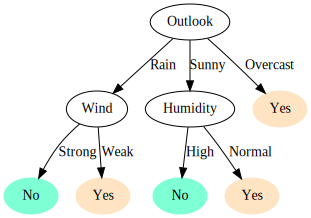

In [10]:
tree, graph = test_tree(dtype='classic', dataset='tennis', train_percent=.8, test_percent=.2,
          split_function=entropy.get_information_gain_ratio)
graph

### - Iris dataset with Gini split criterion
- Naive split of continuous data (Take the mean value as candidate split)

Train score :  0.816666666667
Test score :  0.8


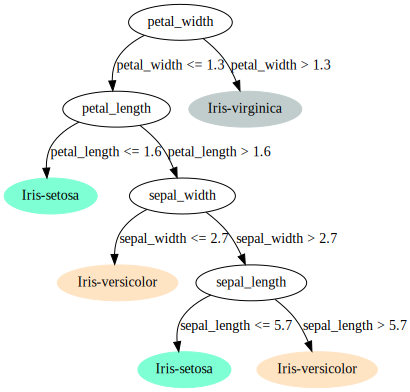

In [11]:
tree, graph = test_tree(dtype='classic', dataset='iris', train_percent=.8, test_percent=.2,
          split_function=gini.get_gini_split)
graph

# Continuous attributes
- To deal with continuous data, I used an SVM classifier.
- First, I check what is the best feature to split on. If the feature is categorical, than I use the classic split method. Otherwise I use an __SVM model to determine the best split thresholds.__ and creates multiple branchs where each represents a class.
- First, I tried to create a tree with multiple levels, even after using an SVM model to split the data. When I tested the decision tree with the mnist dataset, I obtained an __accuracy of 77.32%__ on test data with a tree of __n levels where n is the number of features__. Than, I tried to __stop building the tree (create Leaf nodes for each class), when I use an SVM model for the first time__. With the second method I had __76.75%__ of accuracy with a tree of __1 level__. Because of the following results, the second method is used in the decision tree.

- Here, I will be using PCA to reduce dimensionality from 784 to 10.

Train score :  0.77025
Test score :  0.7675


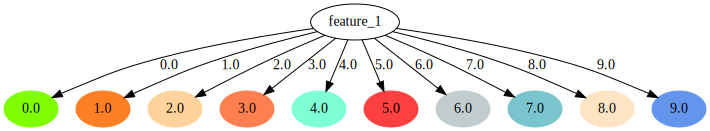

In [13]:
tree, graph = test_tree(dtype='continuous', dataset='mnist', train_percent=.8, test_percent=.2,
          split_function=gini.get_gini_split, nb_features=10)
graph

# Pruning

## * Postpruning:
- When building the tree, if the __percent of a label__ in the data is __greater than a stop_threshold__, The __remaining labels__ are considered as __noise__, and a __Leaf is created__ for the node.
- The __default value__ of the stop_threshold is __90%__, but it can be set by the user.

## * Prepruning: Reduced Error Pruning:
- Consider each node for pruning
- A node is removed if the resulting tree performs no worse then the original on the validation set - removes coincidences and errors
- Nodes are removed iteratively choosing the node whose removal most increases the decision tree accuracy on the graph
- Pruning continues until further pruning is harmful
- uses training, validation & test sets - effective approach if a large amount of data is available

- __Generalization errors__: The expected error of the model on unseen records.

Train score :  1.0
Test score :  1.0


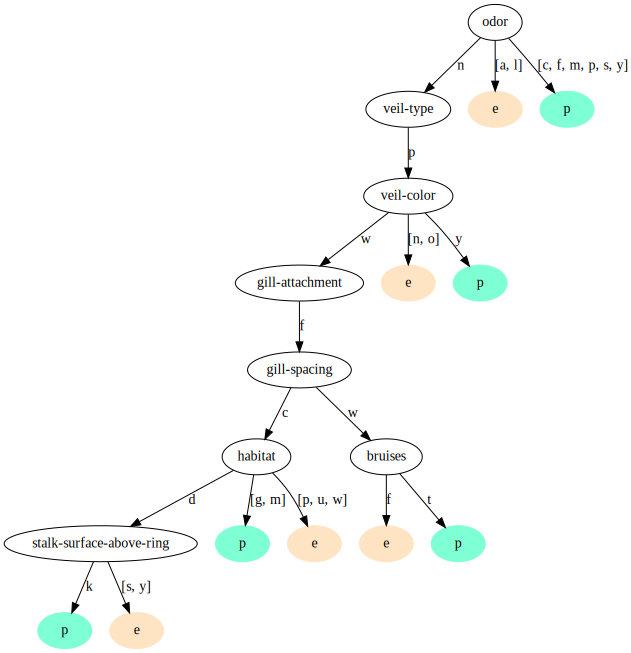

In [10]:
tree, graph = test_tree(dataset='mushrooms', train_percent=.8, test_percent=.2, stop_threshold=1)
graph

- After pruning the tree we have a new __simple tree__ with __1 level__ and __98.71% accuracy__ on test set compared to a __complex tree__ with __6 levels__ and a __100% accuracy__.

Train score :  0.984766887213
Test score :  0.987076923077


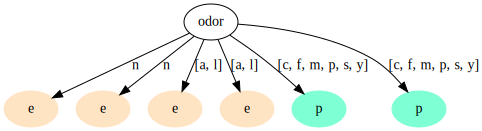

In [9]:
tree, graph = test_tree(dataset='mushrooms', train_percent=.8, test_percent=.2, prune=True, stop_threshold=.9)
graph

# Algorithms

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

0


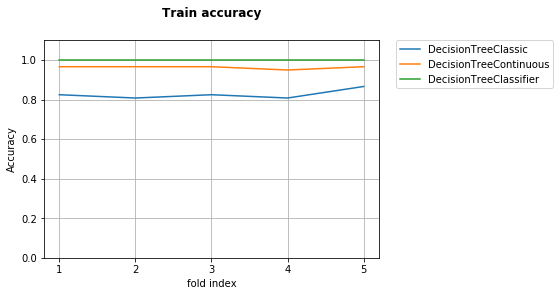

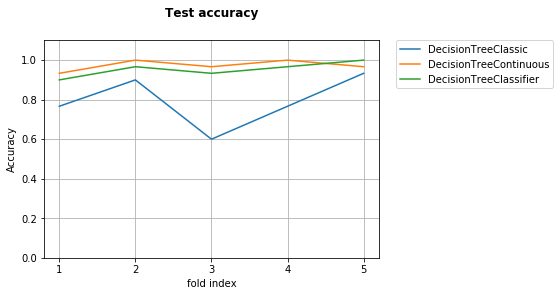

array([ 0.79333333,  0.97333333,  0.95333333])

In [4]:
models = [DecisionTreeClassic(gini.get_gini_split),
          DecisionTreeContinuous(gini.get_gini_split),
          DecisionTreeClassifier()]

train_acc, test_acc = benchmark_models(models, dataset_dict, dataset_name='iris', nb_folds=5)
models_dict = tools.get_models_dict(models)
custom_plot(models_dict, train_acc, 'Train accuracy')
custom_plot(models_dict, test_acc, 'Test accuracy')
np.mean(test_acc, axis=1)

0


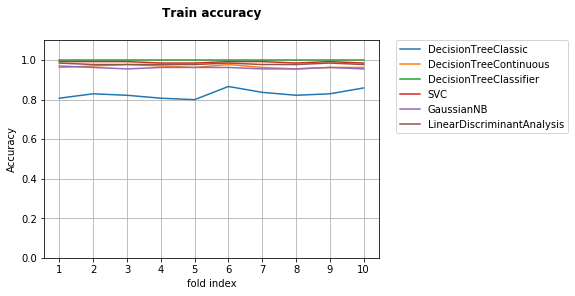

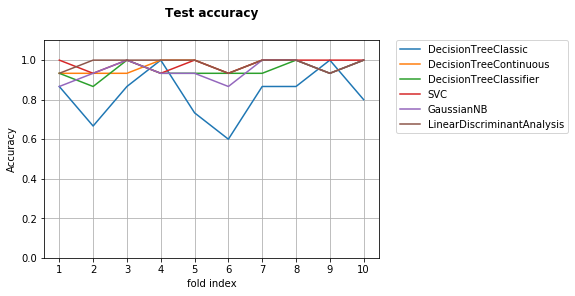

array([ 0.82666667,  0.96666667,  0.94666667,  0.98      ,  0.94666667,
        0.98      ])

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

models = [DecisionTreeClassic(gini.get_gini_split), DecisionTreeContinuous(gini.get_gini_split),
          DecisionTreeClassifier(), svm.SVC(),
          GaussianNB(), LinearDiscriminantAnalysis(n_components=2)]

train_acc, test_acc = benchmark_models(models, dataset_dict, dataset_name='iris', nb_folds=10)
models_dict = tools.get_models_dict(models)
custom_plot(models_dict, train_acc, 'Train accuracy')
custom_plot(models_dict, test_acc, 'Test accuracy')
np.mean(test_acc, axis=1)